# Entendendo LSTM para Previsão de Ações - Passo a Passo

Este notebook vai te ensinar **do zero** como funciona o modelo LSTM que implementamos.

## Objetivo

Ao final deste notebook, você vai entender:
1. O que é LSTM e por que usar para previsão de séries temporais
2. Como preparar dados de ações para LSTM
3. Como treinar o modelo (passo a passo)
4. Como avaliar e interpretar as métricas (MAE, RMSE, MAPE)
5. Como fazer previsões

## Conceitos Fundamentais

### O que é Série Temporal?
Uma sequência de dados coletados ao longo do tempo. Exemplo: preço de ações por dia.

### Por que LSTM?
- **LSTM** = Long Short-Term Memory (Memória de Longo e Curto Prazo)
- É uma rede neural que **lembra** informações passadas
- Perfeito para dados que dependem do histórico (como preços de ações)

### Como LSTM funciona?
- Recebe uma **sequência** de dados (ex: 60 dias de preços)
- Aprende **padrões** nessa sequência
- Usa esses padrões para **prever o futuro**

---

Vamos começar!


## Passo 1: Importar Bibliotecas e Entender o que Cada Uma Faz

Vamos importar apenas o essencial e entender o papel de cada biblioteca:


In [1]:
# Manipulação de dados
import pandas as pd  # Para trabalhar com tabelas de dados
import numpy as np   # Para operações matemáticas

# Download de dados
import yfinance as yf  # Para baixar dados de ações do Yahoo Finance

# Deep Learning (PyTorch)
import torch           # Framework de deep learning
import torch.nn as nn  # Módulo de redes neurais

# Visualização
import matplotlib.pyplot as plt  # Para criar gráficos
import seaborn as sns           # Para gráficos mais bonitos

# Normalização de dados
from sklearn.preprocessing import MinMaxScaler  # Para colocar dados entre 0 e 1
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Métricas

print("✅ Bibliotecas importadas com sucesso!")
print(f"PyTorch versão: {torch.__version__}")
print(f"CUDA disponível (GPU): {torch.cuda.is_available()}")


✅ Bibliotecas importadas com sucesso!
PyTorch versão: 2.9.1
CUDA disponível (GPU): False


## Passo 2: Baixar Dados de Ações (Coleta de Dados)

Vamos baixar``` dados históricos de uma ação. Vou usar Apple (AAPL) como exemplo.


In [6]:
# Configurações
SYMBOL = "AAPL"  # Símbolo da ação
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

# Baixar dados
print(f"📥 Baixando dados de {SYMBOL}...")
df = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False, auto_adjust=True)

# Verificar se temos MultiIndex e achatar se necessário
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Resetar index para ter a data como coluna (antes de renomear para minúsculas)
df = df.reset_index()

# Renomear colunas para minúsculas
df.columns = [col.lower() for col in df.columns]

# Renomear a coluna de data para timestamp (pode ser 'date' ou 'index')
if 'date' in df.columns:
    df = df.rename(columns={'date': 'timestamp'})
elif 'index' in df.columns:
    df = df.rename(columns={'index': 'timestamp'})

print(f"✅ Dados baixados: {len(df)} registros")
print(f"📅 Período: {df['timestamp'].min()} até {df['timestamp'].max()}")
print(f"\n📊 Primeiras linhas:")
df.head()


📥 Baixando dados de AAPL...
✅ Dados baixados: 1257 registros
📅 Período: 2020-01-02 00:00:00 até 2024-12-30 00:00:00

📊 Primeiras linhas:


,timestamp,close,high,low,open,volume
0,2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
1,2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2,2020-01-06,72.335571,72.374177,70.634554,70.885487,118387200
3,2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
4,2020-01-08,73.153481,73.455080,71.698566,71.698566,132079200


In [7]:
df


,timestamp,close,high,low,open,volume
0,2020-01-02,72.468254,72.528574,71.223252,71.476592,135480400
1,2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2,2020-01-06,72.335571,72.374177,70.634554,70.885487,118387200
3,2020-01-07,71.995361,72.600968,71.775796,72.345212,108872000
4,2020-01-08,73.153481,73.455080,71.698566,71.698566,132079200
...,...,...,...,...,...,...
1252,2024-12-23,254.120682,254.498961,252.308869,253.622933,40858800
1253,2024-12-24,257.037476,257.047410,254.140559,254.339671,23234700
1254,2024-12-26,257.853760,258.928914,256.470034,257.027510,27237100
1255,2024-12-27,254.439209,257.535222,251.920601,256.669114,42355300


## Passo 3: Visualizar os Dados (Entender o que temos)

Sempre visualize seus dados antes de treinar um modelo! Isso te ajuda a entender padrões.


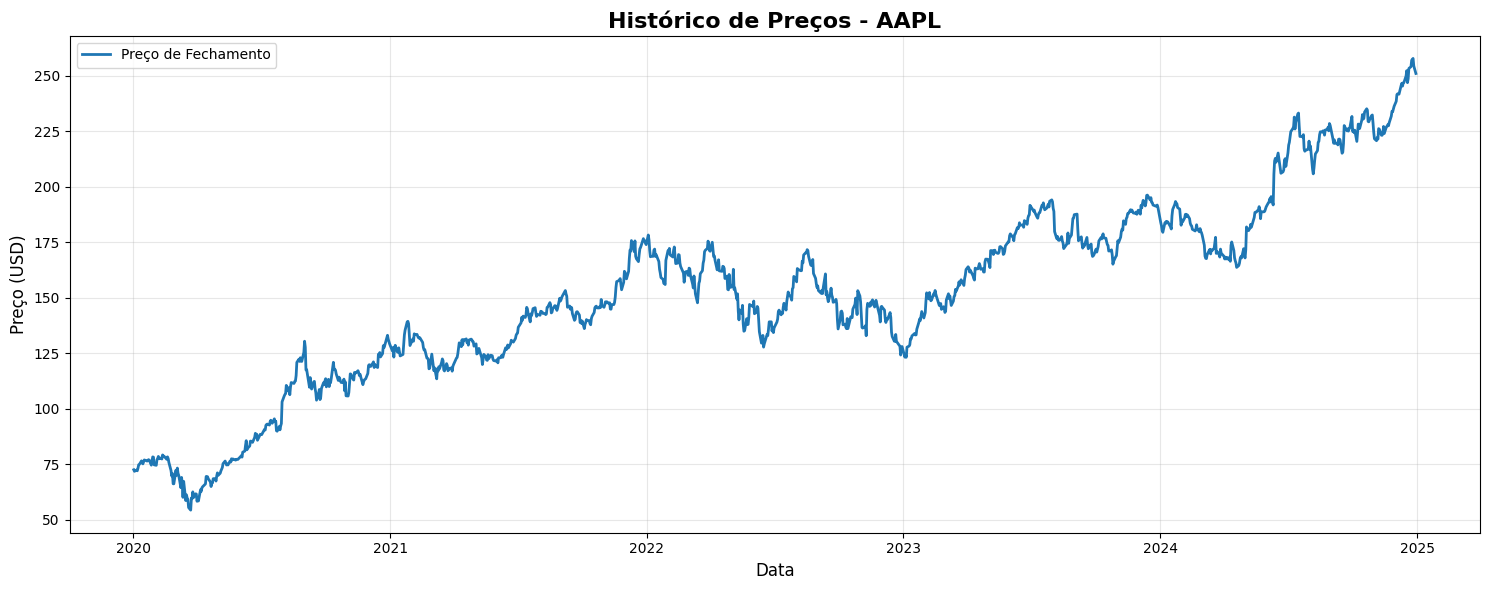

📊 Estatísticas do Preço de Fechamento:
   Mínimo: $54.26
   Máximo: $257.85
   Média: $151.58
   Atual: $251.06


In [8]:
# Gráfico do preço de fechamento ao longo do tempo
plt.figure(figsize=(15, 6))
plt.plot(df['timestamp'], df['close'], label='Preço de Fechamento', linewidth=2)
plt.title(f'Histórico de Preços - {SYMBOL}', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📊 Estatísticas do Preço de Fechamento:")
print(f"   Mínimo: ${df['close'].min():.2f}")
print(f"   Máximo: ${df['close'].max():.2f}")
print(f"   Média: ${df['close'].mean():.2f}")
print(f"   Atual: ${df['close'].iloc[-1]:.2f}")


## Passo 4: Preparar Dados para LSTM

### 🧠 Conceitos Importantes:

1. **Normalização**: Colocar dados entre 0 e 1 ajuda o modelo a aprender melhor
2. **Sequências**: LSTM precisa de sequências (ex: 60 dias) para prever o próximo valor
3. **Train/Test Split**: Dividir dados para treinar e testar o modelo

**Analogia**: É como estudar para uma prova (train) e depois fazer a prova (test) para ver se você realmente aprendeu!


In [9]:
# 1. Pegar apenas o preço de fechamento (vamos começar simples)
data = df['close'].values  # Converter para array numpy
print(f"📊 Dados originais: {data[:5]}")  # Mostrar primeiros 5 valores

# 2. Normalizar dados (colocar entre 0 e 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))  # reshape para formato correto
print(f"📊 Dados normalizados: {data_scaled[:5].flatten()}")  # Mostrar primeiros 5 valores

# 3. Criar sequências
# Exemplo: usar 60 dias para prever o dia 61
SEQUENCE_LENGTH = 60  # Quantos dias usar para prever o próximo

def create_sequences(data, seq_length):
    """
    Cria sequências de dados para LSTM.
    
    Exemplo: Se seq_length=3 e data=[1,2,3,4,5]
    X = [[1,2,3], [2,3,4]]  <- sequências de entrada
    y = [4, 5]              <- valores a prever
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # 60 dias anteriores
        y.append(data[i, 0])                # Dia que queremos prever
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQUENCE_LENGTH)

print(f"\n✅ Sequências criadas:")
print(f"   X shape: {X.shape} <- (amostras, sequence_length)")
print(f"   y shape: {y.shape} <- (valores a prever)")
print(f"\n📝 Exemplo de 1 sequência:")
print(f"   Entrada (X): últimos 5 de 60 dias = {X[0][-5:]}")
print(f"   Saída (y): próximo dia = {y[0]}")


📊 Dados originais: [72.46825409 71.76371765 72.33557129 71.99536133 73.15348053]
📊 Dados normalizados: [0.08941484 0.08595426 0.08876312 0.08709206 0.09278056]

✅ Sequências criadas:
   X shape: (1197, 60) <- (amostras, sequence_length)
   y shape: (1197,) <- (valores a prever)

📝 Exemplo de 1 sequência:
   Entrada (X): últimos 5 de 60 dias = [0.         0.02674054 0.02512491 0.04047312 0.02776219]
   Saída (y): próximo dia = 0.036160843564083


In [10]:
# 4. Dividir em treino e teste
# Importante: em séries temporais, SEMPRE use dados mais antigos para treinar!
TRAIN_RATIO = 0.8  # 80% para treino, 20% para teste

split_idx = int(len(X) * TRAIN_RATIO)

X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

print(f"✅ Dados divididos:")
print(f"   Treino: {len(X_train)} amostras")
print(f"   Teste: {len(X_test)} amostras")
print(f"\n📅 Período de treino: primeiros {TRAIN_RATIO*100:.0f}%")
print(f"📅 Período de teste: últimos {(1-TRAIN_RATIO)*100:.0f}%")

# 5. Converter para tensores PyTorch (formato que o modelo entende)
# Adicionar dimensão extra para features: (samples, sequence_length, features)
X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
y_test_tensor = torch.FloatTensor(y_test)

print(f"\n🔢 Formato dos tensores:")
print(f"   X_train: {X_train_tensor.shape} <- (samples, sequence, features)")
print(f"   y_train: {y_train_tensor.shape} <- (samples)")



✅ Dados divididos:
   Treino: 957 amostras
   Teste: 240 amostras

📅 Período de treino: primeiros 80%
📅 Período de teste: últimos 20%

🔢 Formato dos tensores:
   X_train: torch.Size([957, 60, 1]) <- (samples, sequence, features)
   y_train: torch.Size([957]) <- (samples)


## Passo 5: Criar o Modelo LSTM (A Parte Mais Importante!)

### 🧠 O que é um Modelo LSTM?

Imagine que você está tentando prever o clima de amanhã. Você não olha só o clima de hoje, mas dos últimos dias, certo? LSTM faz isso com dados!

**Componentes do nosso modelo:**
1. **LSTM Layer**: A "memória" que lembra padrões dos últimos 60 dias
2. **Dropout**: "Esquece" alguns neurônios aleatoriamente durante treino (evita decorar)
3. **Fully Connected Layer**: Transforma a saída do LSTM em uma previsão de preço

**Hiperparâmetros importantes:**
- `input_size=1`: 1 feature (só o preço de fechamento)
- `hidden_size=50`: 50 "neurônios de memória"
- `num_layers=2`: 2 camadas LSTM (mais profundidade)
- `dropout=0.2`: Desliga 20% dos neurônios aleatoriamente


In [11]:
class SimpleLSTM(nn.Module):
    """
    Modelo LSTM Simples para Previsão de Séries Temporais
    
    Estrutura:
    Input (60 dias) -> LSTM (memória) -> Dropout -> FC Layer -> Output (1 previsão)
    """
    
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        
        # Camada LSTM - a "memória" do modelo
        self.lstm = nn.LSTM(
            input_size=input_size,    # 1 feature (preço)
            hidden_size=hidden_size,  # 50 neurônios de memória
            num_layers=num_layers,    # 2 camadas empilhadas
            batch_first=True,         # (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout adicional
        self.dropout = nn.Dropout(dropout)
        
        # Camada fully connected - transforma saída LSTM em previsão
        self.fc = nn.Linear(hidden_size, 1)  # 50 -> 1 previsão
    
    def forward(self, x):
        """
        Forward pass: x passa pelo modelo
        
        Args:
            x: tensor de shape (batch_size, sequence_length, input_size)
        
        Returns:
            previsão de shape (batch_size, 1)
        """
        # LSTM processa a sequência
        lstm_out, _ = self.lstm(x)
        
        # Pegar apenas a última saída da sequência
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Aplicar dropout
        last_output = self.dropout(last_output)
        
        # Previsão final
        prediction = self.fc(last_output)  # (batch, 1)
        
        return prediction

# Criar o modelo
model = SimpleLSTM(
    input_size=1,     # 1 feature
    hidden_size=50,   # 50 neurônios
    num_layers=2,     # 2 camadas
    dropout=0.2       # 20% dropout
)

print("🧠 Modelo criado!")
print(f"\n📊 Arquitetura do modelo:")
print(model)
print(f"\n🔢 Total de parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



🧠 Modelo criado!

📊 Arquitetura do modelo:
SimpleLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

🔢 Total de parâmetros treináveis: 31,051


## Passo 6: Treinar o Modelo

### 🎯 O que é Treinamento?

**Analogia**: É como aprender a andar de bicicleta!
- Você cai, ajusta, tenta de novo
- Cada vez você erra menos
- Depois de muitas tentativas, você aprende!

**No modelo:**
1. **Epoch**: Uma passagem completa pelos dados de treino
2. **Loss (Erro)**: O quanto o modelo está errando
3. **Optimizer (Adam)**: Ajusta os pesos do modelo para errar menos
4. **Learning Rate**: Velocidade do aprendizado (0.001 = devagar e constante)

Vamos treinar por 20 epochs (passadas) para ver o modelo aprender!


In [12]:
# Configurar treinamento
EPOCHS = 20           # Número de passadas pelos dados
LEARNING_RATE = 0.001 # Velocidade de aprendizado
BATCH_SIZE = 32       # Processar 32 amostras por vez

# Loss function: mede o erro
criterion = nn.MSELoss()  # Mean Squared Error - quanto maior, pior

# Optimizer: ajusta os pesos
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Listas para guardar o histórico
train_losses = []

print("🚀 Iniciando treinamento...")
print(f"   Epochs: {EPOCHS}")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Batch Size: {BATCH_SIZE}")
print("="*60)

# Loop de treinamento
for epoch in range(EPOCHS):
    model.train()  # Modo treino
    
    # Processar dados em batches
    total_loss = 0
    num_batches = 0
    
    for i in range(0, len(X_train_tensor), BATCH_SIZE):
        # Pegar batch
        batch_X = X_train_tensor[i:i+BATCH_SIZE]
        batch_y = y_train_tensor[i:i+BATCH_SIZE]
        
        # 1. Zerar gradientes
        optimizer.zero_grad()
        
        # 2. Forward pass - fazer previsão
        predictions = model(batch_X)
        
        # 3. Calcular erro (loss)
        loss = criterion(predictions.squeeze(), batch_y)
        
        # 4. Backward pass - calcular gradientes
        loss.backward()
        
        # 5. Atualizar pesos
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    # Calcular loss média do epoch
    avg_loss = total_loss / num_batches
    train_losses.append(avg_loss)
    
    # Mostrar progresso a cada 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.6f}")

print("="*60)
print("✅ Treinamento concluído!")
print(f"📉 Loss inicial: {train_losses[0]:.6f}")
print(f"📉 Loss final: {train_losses[-1]:.6f}")
print(f"📈 Melhoria: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%")


🚀 Iniciando treinamento...
   Epochs: 20
   Learning Rate: 0.001
   Batch Size: 32
Epoch [5/20] - Loss: 0.022133
Epoch [10/20] - Loss: 0.004222
Epoch [15/20] - Loss: 0.002566
Epoch [20/20] - Loss: 0.003463
✅ Treinamento concluído!
📉 Loss inicial: 0.021421
📉 Loss final: 0.003463
📈 Melhoria: 83.8%


/var/folders/tg/kbfbcwq176z9_3rxr1cd0c_80000gn/T/ipykernel_79279/3967568506.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/henriquebap/Pessoal/PosTech/previsao_acoes/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


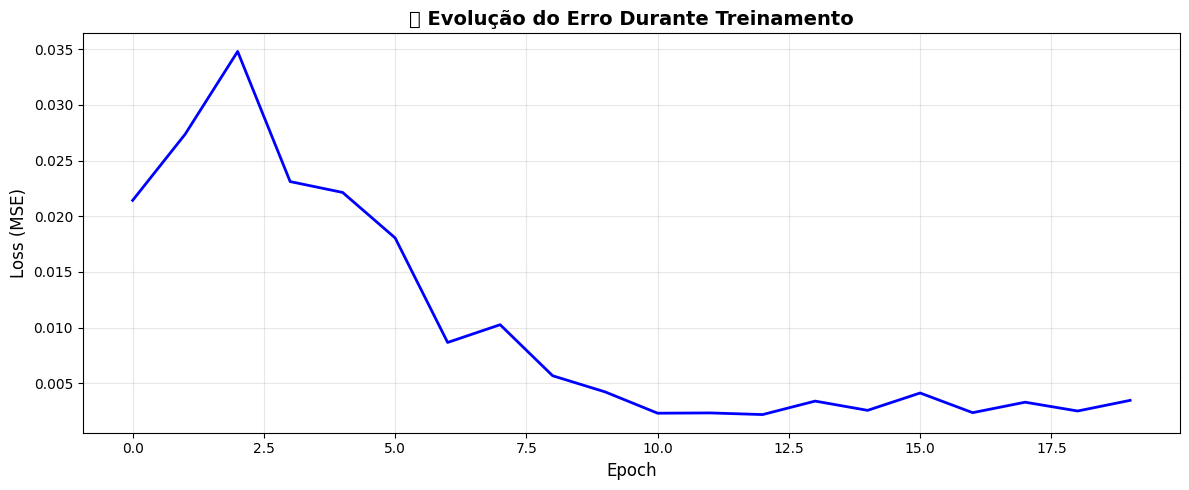

💡 Interpretação:
   - Loss começou alto e foi diminuindo = Modelo está aprendendo! ✅
   - Se loss ficasse constante = Modelo não aprenderia nada ❌
   - Se loss aumentasse = Algo errado com hiperparâmetros ❌


In [13]:
# Visualizar a evolução do treinamento
plt.figure(figsize=(12, 5))
plt.plot(train_losses, linewidth=2, color='blue')
plt.title('📉 Evolução do Erro Durante Treinamento', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Interpretação:")
print("   - Loss começou alto e foi diminuindo = Modelo está aprendendo! ✅")
print("   - Se loss ficasse constante = Modelo não aprenderia nada ❌")
print("   - Se loss aumentasse = Algo errado com hiperparâmetros ❌")


## Passo 7: Avaliar o Modelo (As Métricas do PDF!)

Agora vamos testar o modelo com dados que ele NUNCA viu (conjunto de teste).

### 📊 Métricas Importantes:

1. **MAE** (Mean Absolute Error)
   - Erro médio absoluto
   - Quanto o modelo erra em média (em dólares)
   - **Quanto menor, melhor!**

2. **RMSE** (Root Mean Square Error)
   - Raiz do erro quadrático médio
   - Penaliza erros grandes mais fortemente
   - **Quanto menor, melhor!**

3. **MAPE** (Mean Absolute Percentage Error)
   - Erro percentual médio
   - Mostra o erro em %
   - **Quanto menor, melhor!** (< 10% é excelente)


In [14]:
# Fazer previsões no conjunto de teste
model.eval()  # Modo avaliação (desliga dropout)

with torch.no_grad():  # Não calcular gradientes (mais rápido)
    predictions_scaled = model(X_test_tensor).squeeze().numpy()

# Desnormalizar previsões e valores reais
predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Calcular as 3 métricas principais do PDF
mae = mean_absolute_error(y_test_real, predictions)
rmse = np.sqrt(mean_squared_error(y_test_real, predictions))
mape = np.mean(np.abs((y_test_real - predictions) / y_test_real)) * 100

print("="*60)
print("📊 MÉTRICAS DE AVALIAÇÃO (Requisitos do PDF)")
print("="*60)
print(f"\n✅ MAE (Mean Absolute Error):  ${mae:.2f}")
print(f"   → O modelo erra em média ${mae:.2f} por previsão")
print(f"\n✅ RMSE (Root Mean Square Error): ${rmse:.2f}")
print(f"   → Penaliza erros grandes: ${rmse:.2f}")
print(f"\n✅ MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"   → O modelo erra em média {mape:.2f}% do valor real")

# Interpretação
print(f"\n💡 Interpretação:")
if mape < 5:
    print(f"   🌟 Excelente! MAPE < 5%")
elif mape < 10:
    print(f"   ✅ Muito bom! MAPE < 10%")
elif mape < 20:
    print(f"   👍 Bom! MAPE < 20%")
else:
    print(f"   ⚠️  Modelo pode melhorar. MAPE > 20%")

print("="*60)


📊 MÉTRICAS DE AVALIAÇÃO (Requisitos do PDF)

✅ MAE (Mean Absolute Error):  $8.75
   → O modelo erra em média $8.75 por previsão

✅ RMSE (Root Mean Square Error): $10.05
   → Penaliza erros grandes: $10.05

✅ MAPE (Mean Absolute Percentage Error): 4.26%
   → O modelo erra em média 4.26% do valor real

💡 Interpretação:
   🌟 Excelente! MAPE < 5%


## Passo 8: Visualizar Previsões vs Realidade

Vamos ver graficamente como o modelo se saiu!


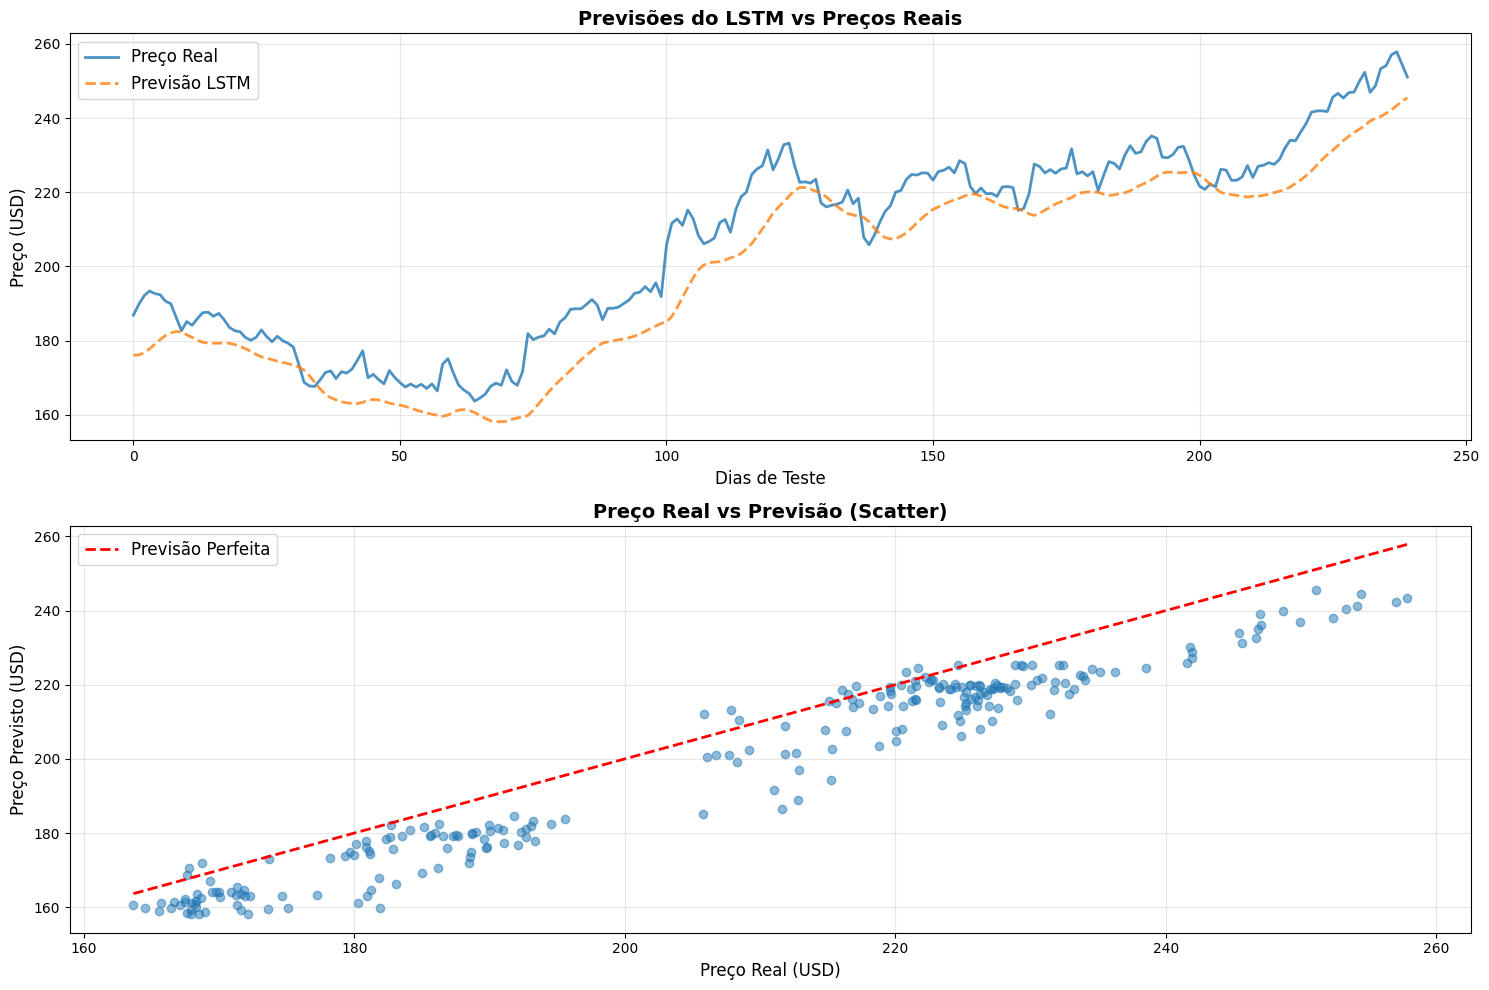

💡 Como interpretar os gráficos:
   Gráfico 1: As linhas devem ficar próximas = modelo prevê bem
   Gráfico 2: Pontos perto da linha vermelha = previsões precisas


In [15]:
# Criar figura com 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Gráfico 1: Previsões vs Real ao longo do tempo
ax1.plot(y_test_real, label='Preço Real', linewidth=2, alpha=0.8)
ax1.plot(predictions, label='Previsão LSTM', linewidth=2, alpha=0.8, linestyle='--')
ax1.set_title('Previsões do LSTM vs Preços Reais', fontsize=14, fontweight='bold')
ax1.set_xlabel('Dias de Teste', fontsize=12)
ax1.set_ylabel('Preço (USD)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Scatter plot (ideal: pontos na linha diagonal)
ax2.scatter(y_test_real, predictions, alpha=0.5)
ax2.plot([y_test_real.min(), y_test_real.max()], 
         [y_test_real.min(), y_test_real.max()], 
         'r--', linewidth=2, label='Previsão Perfeita')
ax2.set_title('Preço Real vs Previsão (Scatter)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Preço Real (USD)', fontsize=12)
ax2.set_ylabel('Preço Previsto (USD)', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 Como interpretar os gráficos:")
print("   Gráfico 1: As linhas devem ficar próximas = modelo prevê bem")
print("   Gráfico 2: Pontos perto da linha vermelha = previsões precisas")


## Passo 9: Fazer uma Previsão do Futuro! 🔮

Agora vamos usar o modelo para prever o preço do próximo dia!


In [18]:
# Pegar os últimos 60 dias dos dados completos
last_sequence = data_scaled[-SEQUENCE_LENGTH:]  # Últimos 60 dias normalizados

# Converter para tensor
last_sequence_tensor = torch.FloatTensor(last_sequence).unsqueeze(0)
print(f"📊 Shape da entrada: {last_sequence_tensor.shape} <- (1, 60, 1)")

# Fazer previsão
model.eval()
with torch.no_grad():
    next_day_scaled = model(last_sequence_tensor).item()

# Desnormalizar
next_day_price = scaler.inverse_transform([[next_day_scaled]])[0][0]

# Preço atual (último dia dos dados)
current_price = data[-1]

# Calcular mudança
price_change = next_day_price - current_price
price_change_pct = (price_change / current_price) * 100

print("="*60)
print("🔮 PREVISÃO DO PRÓXIMO DIA")
print("="*60)
print(f"\n📅 Data atual: {df['timestamp'].iloc[-1].date()}")
print(f"💰 Preço atual: ${current_price:.2f}")
print(f"\n🎯 Previsão próximo dia: ${next_day_price:.2f}")
print(f"📈 Mudança esperada: ${price_change:+.2f} ({price_change_pct:+.2f}%)")

if price_change > 0:
    print(f"\n📈 Modelo prevê ALTA de {price_change_pct:.2f}%")
else:
    print(f"\n📉 Modelo prevê QUEDA de {abs(price_change_pct):.2f}%")
    
print("="*60)
print("⚠️  DISCLAIMER: Esta é apenas uma previsão educacional!")
print("    NÃO USE para decisões reais de investimento.")


📊 Shape da entrada: torch.Size([1, 60, 1]) <- (1, 60, 1)
🔮 PREVISÃO DO PRÓXIMO DIA

📅 Data atual: 2024-12-30
💰 Preço atual: $251.06

🎯 Previsão próximo dia: $245.75
📈 Mudança esperada: $-5.32 (-2.12%)

📉 Modelo prevê QUEDA de 2.12%
⚠️  DISCLAIMER: Esta é apenas uma previsão educacional!
    NÃO USE para decisões reais de investimento.


## Resumo: O que Você Aprendeu

### Conceitos Principais

1. **LSTM (Long Short-Term Memory)**
   - Tipo de rede neural para séries temporais
   - "Lembra" de padrões dos últimos N dias (60 no nosso caso)
   - Usa essas memórias para prever o futuro

2. **Pipeline Completo de ML**
   - Coleta de dados (yfinance)
   - Normalização (MinMaxScaler)
   - Criação de sequências
   - Train/Test split
   - Treinamento
   - Avaliação
   - Previsão

3. **Métricas de Avaliação** (Requisitos do PDF)
   - **MAE**: Erro médio em dólares
   - **RMSE**: Erro penalizando grandes erros
   - **MAPE**: Erro percentual médio

### Componentes do Modelo

```
Input (60 dias de preços)
    ↓
LSTM Layer (50 neurônios, 2 camadas)
    ↓
Dropout (20%)
    ↓
Fully Connected Layer
    ↓
Output (previsão de 1 dia)
```

### Hiperparâmetros Importantes

- `sequence_length = 60`: quantos dias olhar para trás
- `hidden_size = 50`: quantos neurônios de memória
- `num_layers = 2`: quantas camadas LSTM
- `dropout = 0.2`: % de neurônios desligados (evita overfitting)
- `learning_rate = 0.001`: velocidade de aprendizado
- `epochs = 20`: quantas passadas pelos dados
- `batch_size = 32`: quantas amostras por vez

---


## Materiais de Estudo Recomendados

### Foque nestas aulas:
1. **Redes Neurais e Deep Learning**
   - Aula 2: Teoria das Redes Neurais ⭐⭐⭐
   - Aula 3: Arquiteturas (LSTM) ⭐⭐⭐
   - Aula 4: Técnicas de Aplicação ⭐⭐

### Conceitos para entender melhor:
- Backpropagation
- Gradiente descendente
- Função de perda (Loss)
- Optimizers (Adam, SGD)
- Overfitting vs Underfitting

---

## Importante Lembrar

1. **Limitações do modelo:**
   - Só usa dados históricos de preços
   - Não considera notícias, eventos econômicos
   - Passado não garante futuro

2. **O que você pode explicar agora:**
   - Como LSTM funciona
   - Por que normalizar dados
   - O que são MAE, RMSE, MAPE
   - Como treinar e avaliar um modelo
   - Como fazer previsões

---

## Dicas para Apresentação

Se você precisa explicar este projeto:

1. **Comece pelo problema:**
   "Queremos prever preços de ações usando histórico"

2. **Explique por que LSTM:**
   "LSTM é uma rede neural que lembra padrões temporais"

3. **Mostre o pipeline:**
   "Coleta → Normalização → Sequências → Treino → Avaliação"

4. **Apresente as métricas:**
   "Usamos MAE, RMSE e MAPE para avaliar. MAPE de X% significa..."
